In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
import time

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from xgboost import XGBRegressor

<p style='font-size:16px'>All helper functions are in a separate file called <span style='color:green'>functions-final.py</span>, which are in the same folder as this notebook.</p>

In [3]:
from functions_final import create_table, plot_name 
from functions_final import regplot_poly, regplot_lag, regplot_poly_fourier_lag, errorplot_poly_fourier_lag
from functions_final import predict_pfl_recur, plot_pfl_recur, predict_pfl_dir, plot_pfl_dir, predict_pfl_dir_boosted, plot_pfl_dir_boosted

<p style='font-size:16px'>Data downloaded from <a href="https://statbel.fgov.be/nl/themas/bevolking/namen-en-voornamen/voornamen-van-meisjes-en-jongens" target='_blank'>this page</a> of the website of Statbel, the official Belgian statistical office.</p>

In [4]:
xls = pd.ExcelFile('voornamen_jongens.xlsx')
dataframe_jongens = {}

for sheet_name in xls.sheet_names:
    dataframe_jongens[sheet_name] = xls.parse(sheet_name)

In [5]:
xls = pd.ExcelFile('voornamen_meisjes.xlsx')
dataframe_meisjes = {}

for sheet_name in xls.sheet_names:
    dataframe_meisjes[sheet_name] = xls.parse(sheet_name)

<p style='font-size:16px'>Data preparation</p>

In [6]:
for df in dataframe_jongens:
    dataframe_jongens[df].columns = ['België_rang', 'België_naam', 'België_aantal', 'Vlaanderen_rang',  'Vlaanderen_naam', 'Vlaanderen_aantal', 
                                     'Wallonië_rang',  'Wallonië_naam', 'Wallonië_aantal', 'Brussel_rang',  'Brussel_naam', 
                                     'Brussel_aantal']

for df in dataframe_meisjes:
    dataframe_meisjes[df].columns = ['België_rang', 'België_naam', 'België_aantal', 'Vlaanderen_rang',  'Vlaanderen_naam', 'Vlaanderen_aantal', 
                                     'Wallonië_rang',  'Wallonië_naam', 'Wallonië_aantal', 'Brussel_rang',  'Brussel_naam', 
                                     'Brussel_aantal']

In [7]:
aantal_bel_m = create_table(dataframe_jongens, 'België', 'aantal')
aantal_bel_v = create_table(dataframe_meisjes, 'België', 'aantal')
rang_bel_m = create_table(dataframe_jongens, 'België', 'rang')
rang_bel_v = create_table(dataframe_meisjes, 'België', 'rang')

In [8]:
len(aantal_bel_m), len(aantal_bel_v)

(12265, 14022)

<p style='font-size:16px'>There are 12,265 boys' names and 14,022 girls' names in total. We reduce this by only considering names that have been chosen 50 or more times in at least one given year. That leaves us with about 500 names for each gender.</p>

In [9]:
top_names_m = aantal_bel_m[aantal_bel_m.iloc[:,1:-1].max(axis=1) >= 50].drop('1995-2023', axis=1)
top_names_v = aantal_bel_v[aantal_bel_v.iloc[:,1:-1].max(axis=1) >= 50].drop('1995-2023', axis=1)
print(str(len(top_names_m)) + ', ' + str(len(top_names_v)))

522, 526


<p style='font-size:16px'>Below some regression plots on the entire periode 1995-2923. We can consider polynomials on the time steps, Fourier terms, lag terms and of course combinations of all of these. This already results in a good fit for most names.</p>  

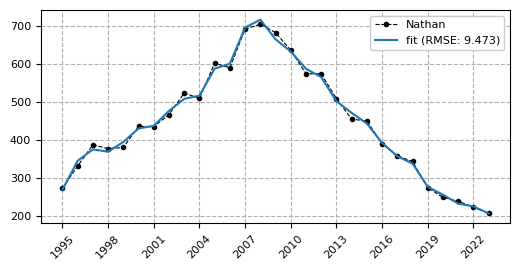

In [10]:
regplot_poly_fourier_lag(top_names_m, 'Nathan', 3, [0.5, 1, 2], 10)

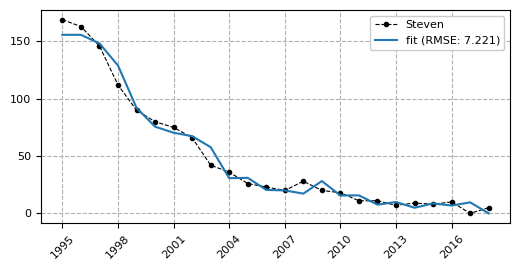

In [11]:
regplot_lag(top_names_m.iloc[:,:-5], 'Steven', 2)

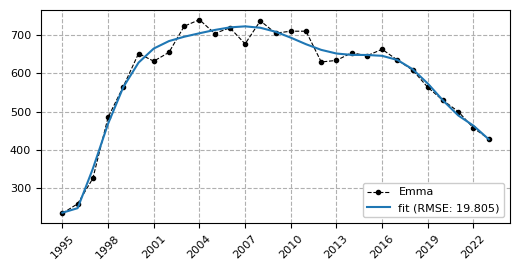

In [12]:
regplot_poly(top_names_v, 'Emma', 10)

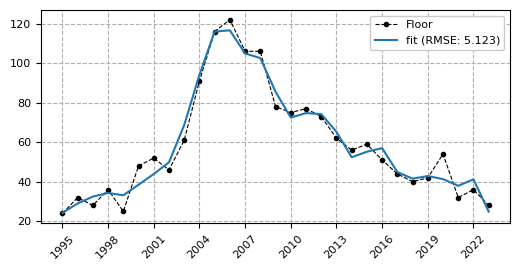

In [13]:
regplot_poly_fourier_lag(top_names_v, 'Floor', 3, [0.5, 1], 10)

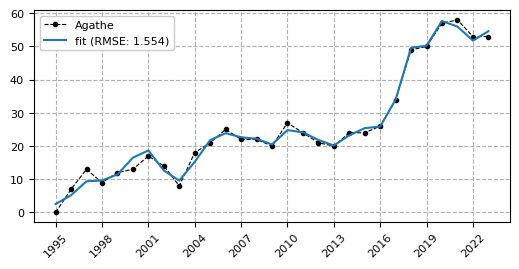

In [14]:
regplot_poly_fourier_lag(top_names_v, 'Agathe', 3, [0.5], 16)

<p style='font-size:16px'>Below we examine the average RMSE for a selection of 100 girls' names, for different combinations of polynomials, Fourier terms and lags. On average, it seems that the more terms used, the better the result.</p>  

In [22]:
RMSE, RMSE_STD = errorplot_poly_fourier_lag(top_names_v[190:290], [2, 3, 4, 5, 6], [0.5, 1, 2, 4], [2, 4, 6, 8, 10, 12])

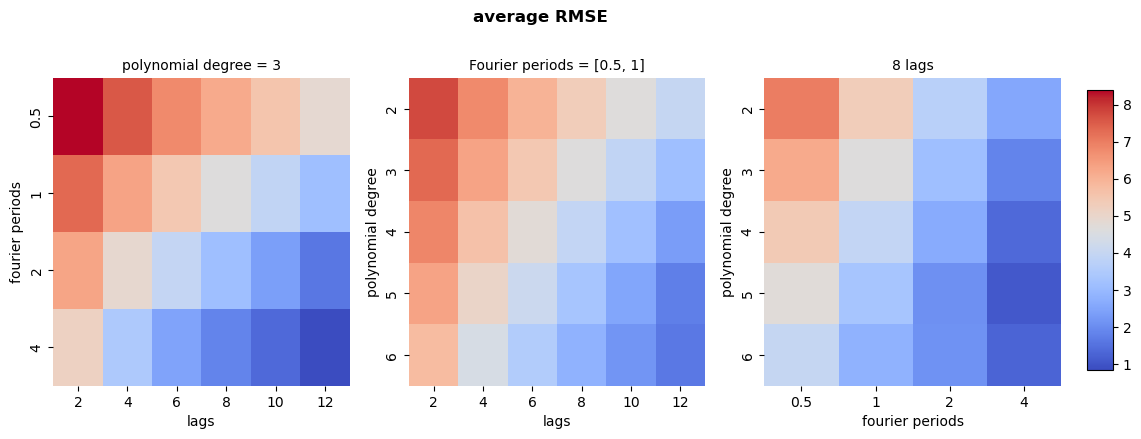

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(13,4),  gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.2})

vmin = min(RMSE[1].min(), RMSE[:,1,:].min(), RMSE[:,:,3].min())
vmax = max(RMSE[1].max(), RMSE[:,1,:].max(), RMSE[:,:,3].max())

fig.suptitle("average RMSE", fontsize=12, fontweight='bold', y=1.05)

hm_1 = sns.heatmap(RMSE[1], ax=axes[0], cmap="coolwarm", vmin=vmin, vmax=vmax, cbar=False, xticklabels=[2, 4, 6, 8, 10, 12], yticklabels=[0.5, 1, 2, 4])
axes[0].set_title("polynomial degree = 3", fontsize=10)
axes[0].set_xlabel("lags", fontsize=10)
axes[0].set_ylabel("fourier periods", fontsize=10)

hm_2 = sns.heatmap(RMSE[:,1,:], ax=axes[1], cmap="coolwarm", vmin=vmin, vmax=vmax, cbar=False, xticklabels=[2, 4, 6, 8, 10, 12], yticklabels=[2, 3, 4, 5, 6])
axes[1].set_title("Fourier periods = [0.5, 1]", fontsize=10)
axes[1].set_xlabel("lags", fontsize=10)
axes[1].set_ylabel("polynomial degree", fontsize=10)

hm_3 = sns.heatmap(RMSE[:,:, 3], ax=axes[2], cmap="coolwarm", vmin=vmin, vmax=vmax, cbar=False, xticklabels=[0.5, 1, 2, 4], yticklabels=[2, 3, 4, 5, 6])
axes[2].set_title("8 lags", fontsize=10)
axes[2].set_xlabel("fourier periods", fontsize=10)
axes[2].set_ylabel("polynomial degree", fontsize=10)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # position for the colorbar
fig.colorbar(hm_3.get_children()[0], cax=cbar_ax) 

plt.show()

<p style='font-size:16px'>Now let's' predict the numbers for the period 2021-2023 based on the data for 1995-2020. We can employ two methods. The recurrent method simply takes the result for year X and adds it as a feature in order to then predict the number for the year X+1.</p>
<p style='font-size:16px'>In the direct method, there is an extra complexity: a new model is fitted upon each step. This is computationally more expensive, but as we are working with a relatively small dataset, that is not an issue here.</p>
<p style='font-size:16px'>The graphs show that different methods lead to different results, and it is not the case that one method is always better than the other. This is also the case for performing XGBoost on the error terms.  Sometimes this leads to a better result, but not always.</p>

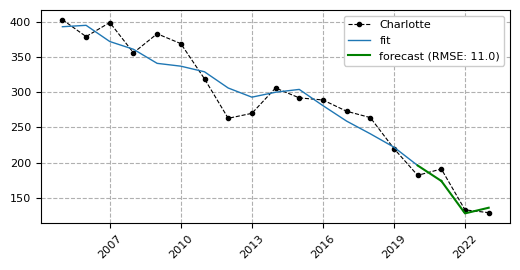

In [15]:
plot_pfl_recur(top_names_v, 'Charlotte', 3, 1, [0.5, 1], 3)

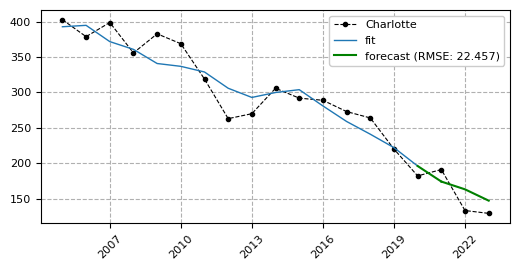

In [16]:
plot_pfl_dir(top_names_v, 'Charlotte', 3, 1, [0.5, 1], 3)

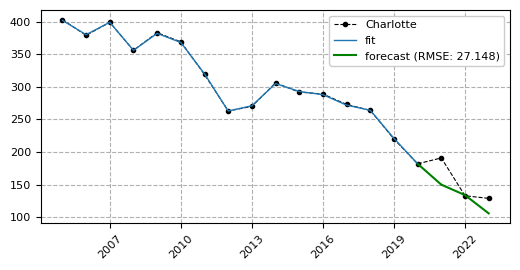

In [17]:
plot_pfl_dir_boosted(top_names_v, 'Charlotte', 3, 1, [0.5, 1], 3)

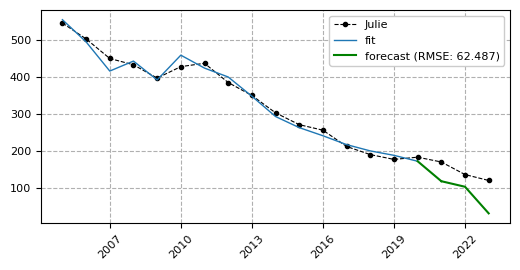

In [18]:
plot_pfl_recur(top_names_v, 'Julie', 3, 2, [0.5, 1], 8)

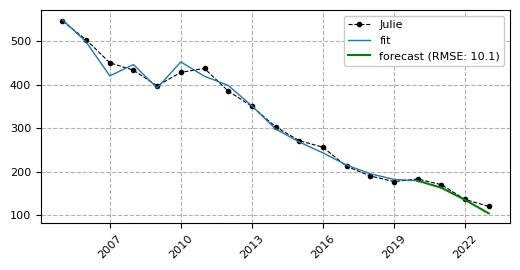

In [19]:
plot_pfl_dir(top_names_v, 'Julie', 3, 1, [0.5, 1], 8)

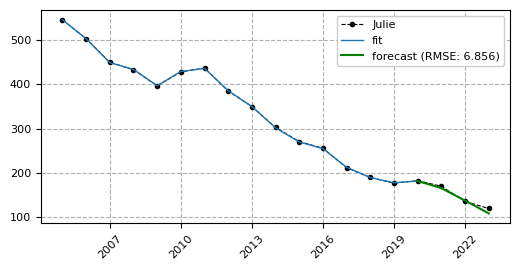

In [20]:
plot_pfl_dir_boosted(top_names_v, 'Julie', 3, 1, [0.5, 1], 8)

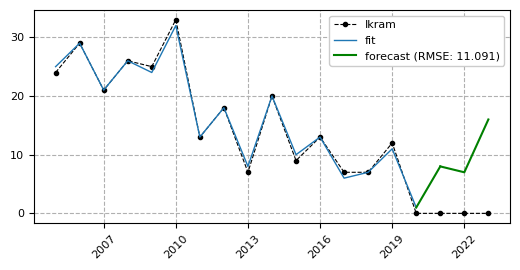

In [21]:
#plot_pfl_dir_boosted(top_names_v, 'Ikram', 3, 1, [0.5, 1], 3)
plot_pfl_dir_boosted(aantal_bel_v.iloc[:,:-1], 'Ikram', 3, 1, [0.5, 1], 3)

<p style='font-size:16px'>Below a grid search helper function is defined. It takes in a range of polynomial degrees, Fourier terms and lags and returns the optimal number for each, for any given name. It also compares models with and without modelling of the error terms. Optimal meaning: the lowest RMSE.</p> 

In [21]:
def grid_search_pfl(df, naam, steps, d, periods, lags):

    row = pd.DataFrame(df[df['naam'] == naam].iloc[0,1:]).reset_index()
    row.columns = ['jaar', 'aantal']
    row['jaar'] = np.arange(0, df.shape[1]-1, 1)
    y = row['aantal']
    
    RMSE_min = 1000
    RMSE = []
    
    for i in range(len(d)):
        for j in range(len(periods)):
            for k in range(len(lags)):
    
                y_0, y_pred = predict_pfl_dir(df.iloc[:,:-steps], naam, steps, d[i], periods[j], lags[k])
                y2 = y_pred[-steps:]
                RMSE_noboost = mean_squared_error(y2, y[-steps:])**(1/2)

                y_0, y_pred = predict_pfl_dir_boosted(df.iloc[:,:-steps], naam, steps, d[i], periods[j], lags[k])
                y2 = y_pred[-steps:]
                RMSE_boost = mean_squared_error(y2, y[-steps:])**(1/2)
    
                RMSE.append(min(RMSE_noboost, RMSE_boost))
                
                if RMSE[-1] < RMSE_min:
                    i_f = i
                    j_f = j
                    k_f = k
                    RMSE_min = RMSE[-1]
                    boost = RMSE_boost < RMSE_noboost

    return d[i_f], periods[j_f], lags[k_f], RMSE_min, boost

<p style='font-size:16px'>Examples below of some results of the grid search.</p>

In [22]:
grid_search_pfl(aantal_bel_v.iloc[:,:-1], 'Ikram', 3, [0, 1, 2, 3, 4], [[0.5], [0.5, 1], [0.5, 1, 2], [0.5, 1, 2, 4]], 
                [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18])

(0, [0.5, 1], 9, 0.0, False)

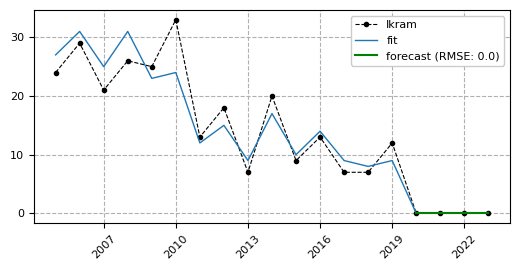

In [24]:
plot_pfl_dir(aantal_bel_v.iloc[:,:-1], 'Ikram', 3, 0, [0.5, 1], 9)

In [25]:
grid_search_pfl(top_names_v, 'Charlotte', 3, [0, 1, 2, 3, 4], [[0.5], [0.5, 1], [0.5, 1, 2], [0.5, 1, 2, 4]], 
                                                    [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18])

(1, [0.5], 7, 14.719601443879744, False)

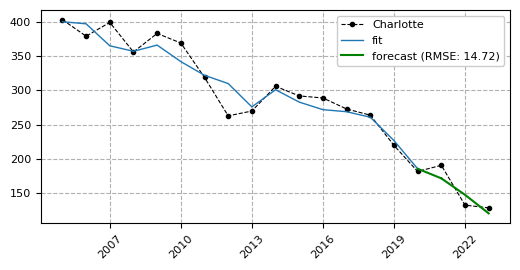

In [26]:
plot_pfl_dir(top_names_v, 'Charlotte', 3, 1, [0.5], 7)

In [27]:
grid_search_pfl(top_names_v, 'Julie', 3, [0, 1, 2, 3, 4], [[0.5], [0.5, 1], [0.5, 1, 2], [0.5, 1, 2, 4]], 
                                                    [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18])

(2, [0.5], 8, 4.320493798938574, True)

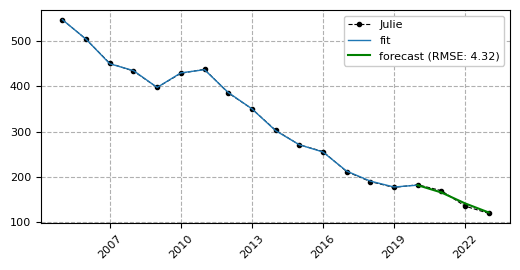

In [28]:
plot_pfl_dir_boosted(top_names_v, 'Julie', 3, 2, [0.5], 8)

<p style='font-size:16px'>We now perform the grid search for all 552 boys' names and 526 girls' names, and store the resulting hyperparameters.</p>

In [29]:
start_time = time.time()

steps = 3

d = [0, 1, 2, 3, 4]
periods = [[0.5], [0.5, 1], [0.5, 1, 2], [0.5, 1, 2, 4]]
lags = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18]

df = top_names_v

top_names_v_gs = df.iloc[:,[0]]
top_names_v_gs.loc[:,['degree', 'periods', 'lags', 'RMSE_forecast', 'boosted']] = None

for i in range(len(df)):

    d_hat, periods_hat, lags_hat, RMSE_hat, boosted = grid_search_pfl(df, df.iloc[i,0], steps, d, periods, lags)

    top_names_v_gs.iloc[i, 1] = d_hat
    top_names_v_gs.iloc[i, 2] = max(periods_hat)
    top_names_v_gs.iloc[i, 3] = lags_hat
    top_names_v_gs.iloc[i, 4] = RMSE_hat
    top_names_v_gs.iloc[i, 5] = boosted

    if i % 5 == 0:
        print(str(100*(i+1)/len(df)) + '% done.')

end_time = time.time()
elapsed_time = end_time - start_time
print('')
print(f"Time: {elapsed_time:.5f} seconds")

0.19011406844106463% done.
1.1406844106463878% done.
2.091254752851711% done.
3.041825095057034% done.
3.9923954372623576% done.
4.942965779467681% done.
5.893536121673004% done.
6.844106463878327% done.
7.79467680608365% done.
8.745247148288973% done.
9.695817490494296% done.
10.64638783269962% done.
11.596958174904943% done.
12.547528517110266% done.
13.49809885931559% done.
14.448669201520913% done.
15.399239543726235% done.
16.34980988593156% done.
17.30038022813688% done.
18.250950570342205% done.
19.20152091254753% done.
20.15209125475285% done.
21.102661596958175% done.
22.0532319391635% done.
23.00380228136882% done.
23.954372623574145% done.
24.90494296577947% done.
25.85551330798479% done.
26.806083650190114% done.
27.75665399239544% done.
28.70722433460076% done.
29.657794676806084% done.
30.60836501901141% done.
31.55893536121673% done.
32.50950570342205% done.
33.460076045627375% done.
34.4106463878327% done.
35.361216730038024% done.
36.31178707224335% done.
37.2623574144

In [90]:
top_names_v_gs.head()

,naam,degree,periods,lags,RMSE_forecast,boosted
75,Ada,2,4,8,4.396969,False
104,Adeline,2,0.5,16,1.290994,False
147,Adèle,1,1,2,4.203173,True
198,Agathe,1,4,12,2.94392,False
317,Alana,0,0.5,2,2.44949,True


In [24]:
v_gs = pd.read_csv('v_gs.csv')
m_gs = pd.read_csv('m_gs.csv')
m_gs = m_gs.drop('Unnamed: 0', axis=1)

In [25]:
v_gs.describe().T

,count,mean,std,min,25%,50%,75%,max
degree,526.0,0.863118,1.124739,0.0,0.000000,0.000000,1.000000,4.000000
periods,526.0,1.340304,1.143583,0.5,0.500000,1.000000,2.000000,4.000000
lags,526.0,6.260456,4.151263,2.0,3.000000,5.000000,9.000000,18.000000
RMSE_forecast,526.0,4.368748,5.417395,0.0,1.290994,2.857589,5.322906,49.802945


In [26]:
m_gs.describe().T

,count,mean,std,min,25%,50%,75%,max
degree,522.0,1.015326,1.188458,0.0,0.000000,1.000000,2.000000,4.000000
periods,522.0,1.354406,1.199356,0.5,0.500000,1.000000,2.000000,4.000000
lags,522.0,6.214559,3.791082,2.0,3.000000,5.000000,8.000000,18.000000
RMSE_forecast,522.0,4.678997,4.524232,0.0,1.732051,3.366502,6.116813,35.856194


In [27]:
v_gs[v_gs['naam'] == 'Emma']

,naam,degree,periods,lags,RMSE_forecast,boosted
156,Emma,4,0.5,2,2.44949,False


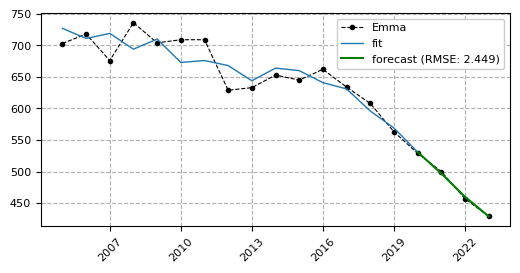

In [28]:
plot_pfl_dir(top_names_v, 'Emma', 3, 4, [0.5], 2)

In [36]:
v_gs[v_gs['naam'] == 'Dounia']

,naam,degree,periods,lags,RMSE_forecast,boosted
126,Dounia,0,4.0,2,2.380476,True


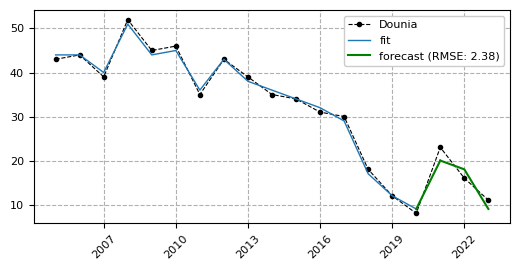

In [37]:
plot_pfl_dir_boosted(top_names_v, 'Dounia', 3, 0, [0.5, 1, 2, 4], 2)

<p style='font-size:16px'>We now run the forecasting model to predict the numbers for 2024. For each individual name, we use the optimal hyperparameters that were found as a result of the grid search.</p> 

In [39]:
v_pred = top_names_v.copy()
m_pred = top_names_m.copy()
v_pred['2024_pred'] = None
m_pred['2024_pred'] = None

In [41]:
start_time = time.time()

for i in range(len(v_pred)):

    naam = v_pred.iloc[i, 0]
    d = v_gs.iloc[i, 1]
    max_period = v_gs.iloc[i, 2]
    lags = v_gs.iloc[i, 3]
    boosted = v_gs.iloc[i, 5]
    
    steps = 1
    
    if max_period == 0.5:
        periods = [0.5]
    elif max_period == 1:
        periods = [0.5, 1]
    elif max_period == 2:
        periods = [0.5, 1, 2]
    else:
        periods = [0.5, 1, 2, 4]

    if boosted == True:
        y_0, y_pred = predict_pfl_dir_boosted(v_pred.iloc[:,:-steps], naam, steps, d, periods, lags)
    else:
        y_0, y_pred = predict_pfl_dir(v_pred.iloc[:,:-steps], naam, steps, d, periods, lags)

    v_pred.iloc[i, -1] = y_pred.iloc[-1]

    if (i+1) % 100 == 0:
        print(f'1/2: {100*(i+1)/len(v_pred)} % done.')

for i in range(len(m_pred)):

    naam = m_pred.iloc[i, 0]
    d = m_gs.iloc[i, 1]
    max_period = m_gs.iloc[i, 2]
    lags = m_gs.iloc[i, 3]
    boosted = m_gs.iloc[i, 5]
    
    steps = 1
    
    if max_period == 0.5:
        periods = [0.5]
    elif max_period == 1:
        periods = [0.5, 1]
    elif max_period == 2:
        periods = [0.5, 1, 2]
    else:
        periods = [0.5, 1, 2, 4]

    if boosted == True:
        y_0, y_pred = predict_pfl_dir_boosted(m_pred.iloc[:,:-steps], naam, steps, d, periods, lags)
    else:
        y_0, y_pred = predict_pfl_dir(m_pred.iloc[:,:-steps], naam, steps, d, periods, lags)

    m_pred.iloc[i, -1] = y_pred.iloc[-1]

    if (i+1) % 100 == 0:
        print(f'2/2: {100*(i+1)/len(m_pred)} % done.')
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time: {elapsed_time:.5f} seconds")

1/2: 19.011406844106464 % done.
1/2: 38.02281368821293 % done.
1/2: 57.034220532319395 % done.
1/2: 76.04562737642586 % done.
1/2: 95.05703422053232 % done.
2/2: 19.157088122605366 % done.
2/2: 38.31417624521073 % done.
2/2: 57.47126436781609 % done.
2/2: 76.62835249042146 % done.
2/2: 95.78544061302682 % done.
Time: 27.45094 seconds


<p style='font-size:16px'>This will be the new Top 5 for girls' names in 2024, as predicted by the model:</p>

In [43]:
v_pred.sort_values(by='2024_pred', ascending=False)[['naam', '2022', '2023', '2024_pred']].head(5)

,naam,2022,2023,2024_pred
10324,Olivia,636.0,587.0,591
335,Alba,261.0,242.0,563
938,Anna,339.0,351.0,480
12159,Sofia,314.0,362.0,438
3657,Emma,457.0,429.0,421


<p style='font-size:16px'>Compare to the Top 5 in 2023.</p>

In [42]:
v_pred.sort_values(by='2023', ascending=False)[['naam', '2021', '2022', '2023']].head(5)

,naam,2021,2022,2023
10324,Olivia,580.0,636.0,587.0
3657,Emma,500.0,457.0,429.0
7624,Louise,455.0,445.0,365.0
7288,Lina,394.0,383.0,362.0
12159,Sofia,359.0,314.0,362.0


<p style='font-size:16px'>And the same for boys' names.</p>

In [44]:
m_pred.sort_values(by='2024_pred', ascending=False)[['naam', '2022', '2023', '2024_pred']].head(5)

,naam,2022,2023,2024_pred
229,Adam,510.0,472.0,613
1021,Arthur,549.0,577.0,603
8396,Noah,657.0,589.0,594
6466,Liam,524.0,498.0,498
10821,Tiago,114.0,97.0,410


In [45]:
m_pred.sort_values(by='2023', ascending=False)[['naam', '2021', '2022', '2023']].head(5)

,naam,2021,2022,2023
8396,Noah,627.0,657.0,589.0
1021,Arthur,584.0,549.0,577.0
6466,Liam,537.0,524.0,498.0
229,Adam,474.0,510.0,472.0
6655,Louis,558.0,517.0,463.0


<p style='font-size:16px'>Let's plot this out to see how the Top 5 will change.</p>

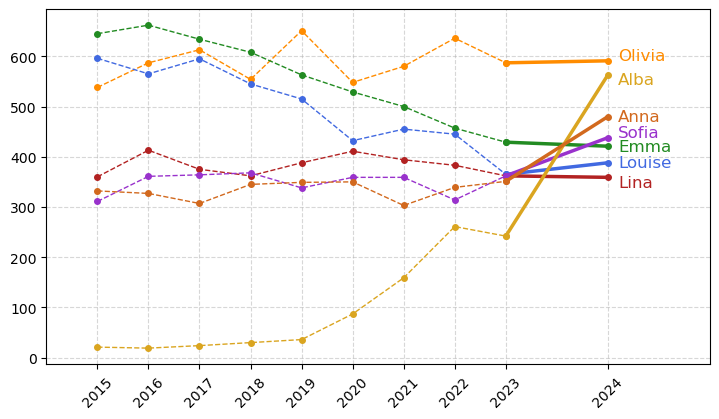

In [56]:
df = v_pred
names = ['Olivia', 'Emma', 'Louise', 'Lina', 'Sofia', 'Alba', 'Anna']

keys = list(range(1995, 2025))

fig, ax = plt.subplots(figsize=(7,4))
x1 = keys[:-1]
x2 = keys[-1]+1

colors=['darkorange', 'forestgreen', 'royalblue', 'firebrick', 'darkorchid', 'goldenrod', 'chocolate']

for i in range(len(names)):

    y_pred = df[df['naam'] == names[i]].iloc[0,1:]
    y1 = y_pred.iloc[:-1]
    y2 = y_pred.iloc[-1]

    ax.plot(x1[20:], y1[20:], linestyle='--', lw=1.0, marker='o', ms=4, label=names[i], color=colors[i]);
    ax.plot(x2, y2, lw=2, color=colors[i]);
    ax.plot([x1[-1], x2], [y1.iloc[-1], y2], lw=2.5, marker='o', ms=4, color=colors[i]);

    if (i == 0) or (i == 4):
        ax.annotate(names[i], xy=(x2, y2), xytext=(x2 + 0.2, y2 + 10), color=colors[i], fontsize=12, verticalalignment="center")
    elif (i == 5) or (i == 3):
        ax.annotate(names[i], xy=(x2, y2), xytext=(x2 + 0.2, y2 - 10), color=colors[i], fontsize=12, verticalalignment="center")
    else:
        ax.annotate(names[i], xy=(x2, y2), xytext=(x2 + 0.2, y2), color=colors[i], fontsize=12, verticalalignment="center")

ax.grid(ls='--', alpha=0.5);
xticks = keys[20:]
xticks[-1] += 1
plt.xticks(xticks, fontsize=10, rotation=45, labels=keys[20:]);
plt.yticks(fontsize=10);
plt.xlim(2014,2027);

plt.tight_layout(pad=0) 
plt.savefig('forecast_girls.png', format='png')
plt.show()

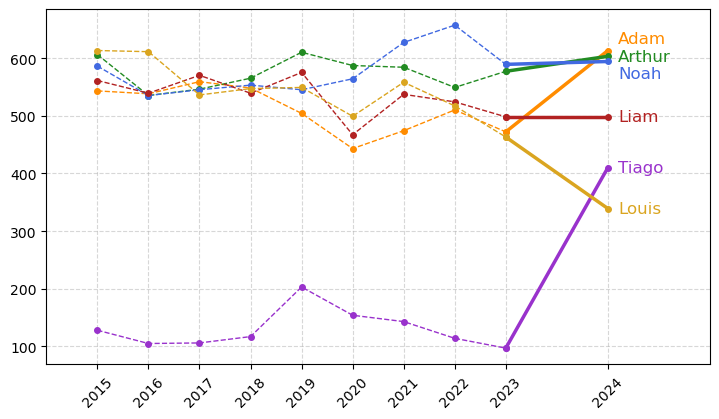

In [57]:
df = m_pred
names = ['Adam', 'Arthur', 'Noah', 'Liam', 'Tiago', 'Louis']

keys = list(range(1995, 2025))

fig, ax = plt.subplots(figsize=(7,4))
x1 = keys[:-1]
x2 = keys[-1]+1

colors=['darkorange', 'forestgreen', 'royalblue', 'firebrick', 'darkorchid', 'goldenrod', 'chocolate']

for i in range(len(names)):

    y_pred = df[df['naam'] == names[i]].iloc[0,1:]
    y1 = y_pred.iloc[:-1]
    y2 = y_pred.iloc[-1]

    ax.plot(x1[20:], y1[20:], linestyle='--', lw=1.0, marker='o', ms=4, label=names[i], color=colors[i]);
    ax.plot(x2, y2, lw=2, color=colors[i]);
    ax.plot([x1[-1], x2], [y1.iloc[-1], y2], lw=2.5, marker='o', ms=4, color=colors[i]);

    if i == 0 :
        ax.annotate(names[i], xy=(x2, y2), xytext=(x2 + 0.2, y2 + 20), color=colors[i], fontsize=12, verticalalignment="center")
    elif i == 2:
        ax.annotate(names[i], xy=(x2, y2), xytext=(x2 + 0.2, y2 - 20), color=colors[i], fontsize=12, verticalalignment="center")
    else:
        ax.annotate(names[i], xy=(x2, y2), xytext=(x2 + 0.2, y2), color=colors[i], fontsize=12, verticalalignment="center")

ax.grid(ls='--', alpha=0.5);
xticks = keys[20:]
xticks[-1] += 1
plt.xticks(xticks, fontsize=10, rotation=45, labels=keys[20:]);
plt.yticks(fontsize=10);
plt.xlim(2014,2027);

plt.tight_layout(pad=0) 
plt.savefig('forecast_boys.png', format='png')
plt.show()